In [2]:
%pip install ccrvam

Note: you may need to restart the kernel to use updated packages.


> Make sure to have ccrvam's latest version installed using `pip`. More information about the latest version can be found at https://pypi.org/project/ccrvam/

In [3]:
import numpy as np
from ccrvam import (
    bootstrap_ccram,
    permutation_test_ccram,
    bootstrap_predict_category_summary
)
from ccrvam import DataProcessor

# 2-Dimensional Case 

### Create Sample Contingency Table

For a 2D contingency table:

- `axis=0`: First variable ($X_1$) with 5 categories
- `axis=1`: Second variable ($X_2$) with 3 categories

The axis indexing follows NumPy's convention, starting from the outermost dimension. The variables are ordered such that:

- $X_1$ corresponds to (rows)
- $X_2$ corresponds to (columns)

This ordering is important for calculating measures of regression association between two variables. And, later on in this `.ipynb`, you can see how we can conveniently mention the 1-indexed variable numbers to perform association measure calculation, regression, and prediction.

In [4]:
contingency_table = np.array([
    [0, 0, 20],
    [0, 10, 0],
    [20, 0, 0],
    [0, 10, 0],
    [0, 0, 20]
])

### Bootstrapping CCRAM & SCCRAM Metrics

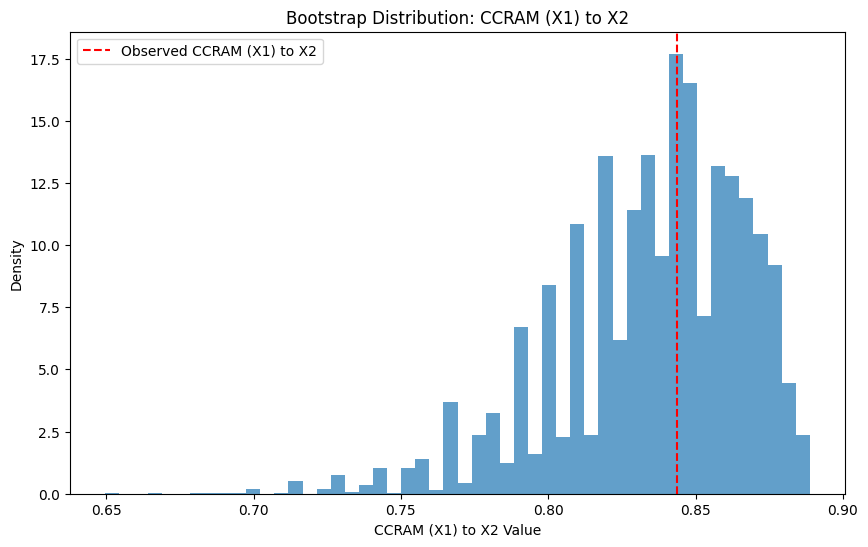

In [5]:
ccram_result = bootstrap_ccram(
    contingency_table,
    predictors=[1],
    response=2,
    confidence_level=0.95,
    method="percentile",
    n_resamples=9999
)

In [6]:
print(f"Metric Name: {ccram_result.metric_name}")
print(f"Observed Value: {ccram_result.observed_value:.4f}")
print(f"95% CI: ({ccram_result.confidence_interval[0]:.4f}, {ccram_result.confidence_interval[1]:.4f})")
print(f"Standard Error: {ccram_result.standard_error:.4f}")
print(f"Bootstrap Distribution: {type(ccram_result.bootstrap_distribution)}")

Metric Name: CCRAM (X1) to X2
Observed Value: 0.8438
95% CI: (0.7556, 0.8809)
Standard Error: 0.0322
Bootstrap Distribution: <class 'numpy.ndarray'>


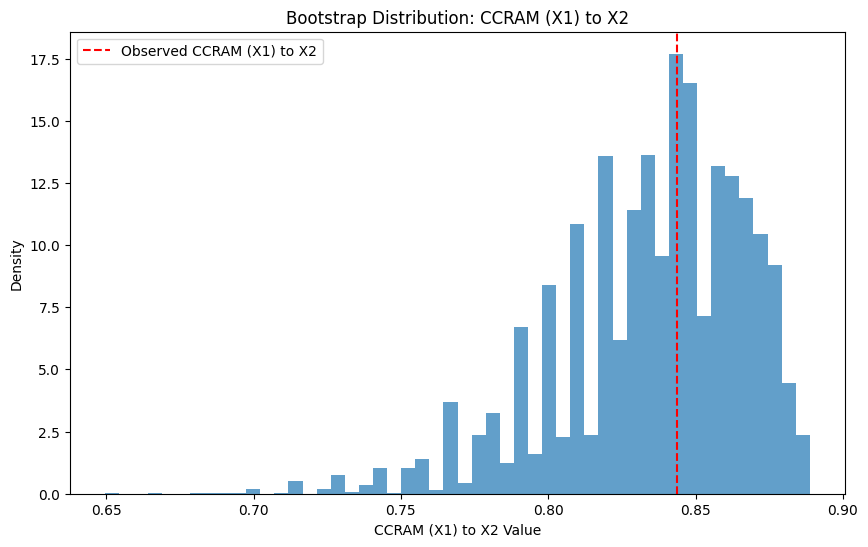

In [7]:
ccram_result.histogram_fig

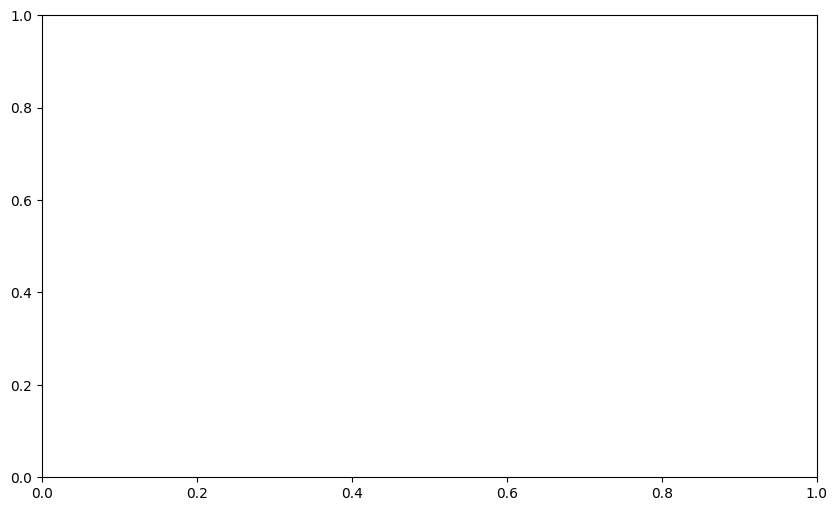

In [8]:
sccram_result = bootstrap_ccram(
    contingency_table,
    predictors=[1],
    response=2,
    scaled=True,
    confidence_level=0.95,
    method="percentile",
    n_resamples=9999
)

In [9]:
print(f"Metric Name: {sccram_result.metric_name}")
print(f"Observed Value: {sccram_result.observed_value:.4f}")
print(f"95% CI: ({sccram_result.confidence_interval[0]:.4f}, {sccram_result.confidence_interval[1]:.4f})")
print(f"Standard Error: {sccram_result.standard_error:.4f}")
print(f"Bootstrap Distribution: {type(sccram_result.bootstrap_distribution)}")

Metric Name: SCCRAM (X1) to X2
Observed Value: 1.0000
95% CI: (1.0000, 1.0000)
Standard Error: 0.0000
Bootstrap Distribution: <class 'numpy.ndarray'>


### Bootstrap Prediction of Categories through Checkerboard Copula Regression

In [10]:
prediction_matrix = bootstrap_predict_category_summary(
    contingency_table,
    predictors=[1],
    predictors_names=["X"],
    response=2,
    response_name="Y",
    n_resamples=9999
)
print("\nPrediction Matrix:")
prediction_matrix

/Users/dhyeymavani/.pyenv/versions/ccrvam/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/dhyeymavani/.pyenv/versions/ccrvam/lib/python3.13/site-packages/numpy/_core/_methods.py:212: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



Prediction Summary (% of bootstrap samples)
--------------------------------------------------------------------------------
       X=0    X=1    X=2    X=3    X=4
Y=0   0.0%   0.0% 100.0%   0.0%   0.0%
Y=1   0.0% 100.0%   0.0% 100.0%   0.0%
Y=2 100.0%   0.0%   0.0%   0.0% 100.0%
--------------------------------------------------------------------------------

Prediction Matrix:


,X=0,X=1,X=2,X=3,X=4
Y=0,0.0,0.0,100.0,0.0,0.0
Y=1,0.0,100.0,0.0,100.0,0.0
Y=2,100.0,0.0,0.0,0.0,100.0


### Permutation Testing for CCRAM & SCCRAM Metrics

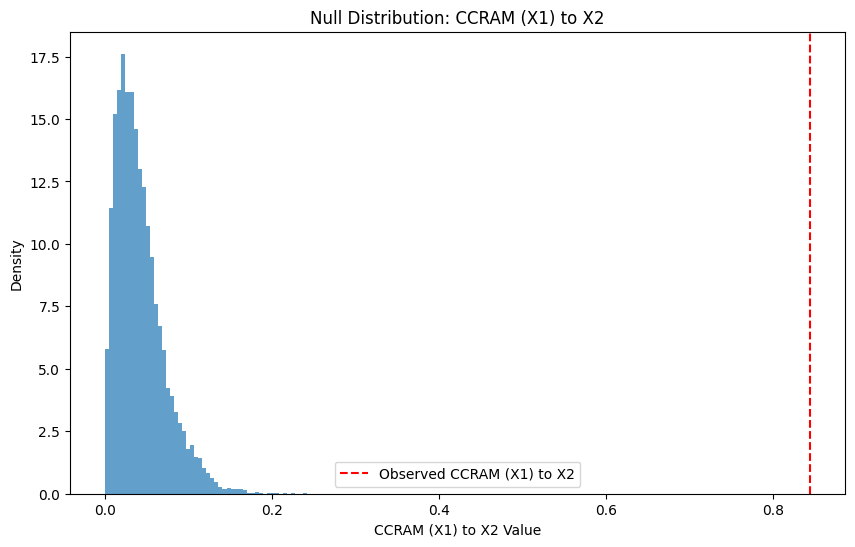

In [11]:
perm_result = permutation_test_ccram(
    contingency_table,
    predictors=[1],
    response=2,
    alternative='greater',
    n_resamples=9999
)

In [12]:
print(f"Metric Name: {perm_result.metric_name}")
print(f"Observed Value: {perm_result.observed_value:.4f}")
print(f"P-Value: {perm_result.p_value:.4f}")
print(f"Null Distribution: {type(perm_result.null_distribution)}")

Metric Name: CCRAM (X1) to X2
Observed Value: 0.8438
P-Value: 0.0001
Null Distribution: <class 'numpy.ndarray'>


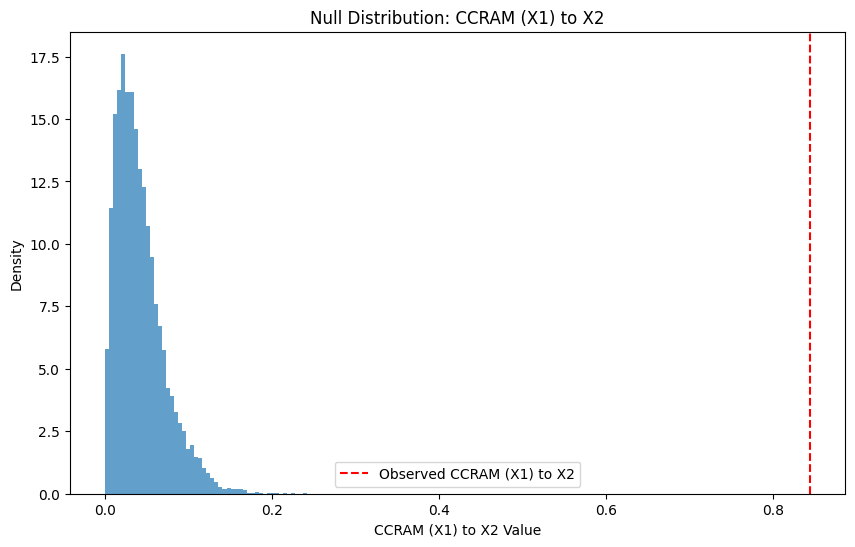

In [13]:
perm_result.histogram_fig

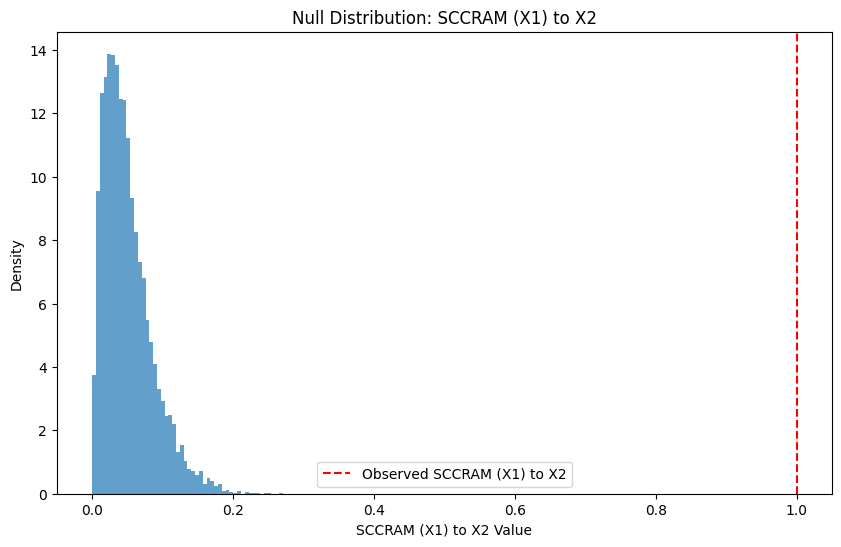

In [14]:
scaled_perm_result = permutation_test_ccram(
    contingency_table,
    predictors=[1],
    response=2,
    scaled=True,
    alternative='greater',
    n_resamples=9999
)

In [15]:
print(f"Metric Name: {scaled_perm_result.metric_name}")
print(f"Observed Value: {scaled_perm_result.observed_value:.4f}")
print(f"P-Value: {scaled_perm_result.p_value:.4f}")
print(f"Null Distribution: {type(scaled_perm_result.null_distribution)}")

Metric Name: SCCRAM (X1) to X2
Observed Value: 1.0000
P-Value: 0.0001
Null Distribution: <class 'numpy.ndarray'>


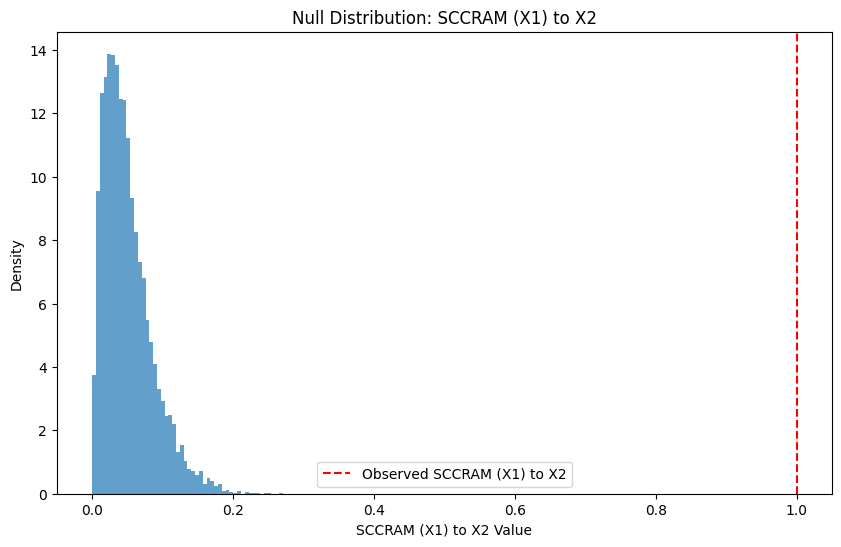

In [16]:
scaled_perm_result.histogram_fig

# 4-Dimensional Case (Real Data Analysis)

### Load Sample Data in Cases / Frequency Form

This example demonstrates analyzing a clinical dataset of back pain treatments using the CCRVAM method.

The dataset contains 4 categorical variables from a medical study:

| Variable | Description | Categories |
|----------|-------------|------------|
| X₁ | Length of Previous Attack | 1=Short, 2=Long |
| X₂ | Pain Change | 1=Better, 2=Same, 3=Worse |
| X₃ | Lordosis | 1=Absent/Decreasing, 2=Present/Increasing |
| X₄ | Back Pain Outcome | 1=Worse (W), 2=Same (S), 3=Slight Improvement (SI), 4=Moderate Improvement (MODI), 5=Marked Improvement (MARI), 6=Complete Relief (CR) |

1. Define variable names and category mappings
2. Load case-form / freq-form data from file with proper mappings into a contingency table

In [17]:
var_list_4d = ["x1", "x2", "x3", "pain"]
category_map_4d = {
    "pain": {
        "worse": 1,
        "same": 2,
        "slight.improvement": 3,
        "moderate.improvement": 4,
        "marked.improvement": 5,
        "complete.relief": 6
    },
}

rda_contingency_table = DataProcessor.load_data(
                        "./data/caseform.pain.txt",
                        data_form="case_form",
                        shape=(2, 3, 2, 6),
                        var_list=var_list_4d,
                        category_map=category_map_4d,
                        named=True,
                        delimiter="\t"
                    )
print("Read contingency table from case form data!")
print(rda_contingency_table)

rda_contingency_table_from_freq = DataProcessor.load_data(
                        "./data/freqform.pain.txt",
                        data_form="frequency_form",
                        shape=(2, 3, 2, 6),
                        var_list=var_list_4d,
                        category_map=category_map_4d,
                        named=True,
                        delimiter="\t"
                    )
print("Read contingency table from frequency form data!")
print(rda_contingency_table_from_freq)

Read contingency table from case form data!
[[[[0 1 0 0 2 4]
   [0 0 0 1 3 0]]

  [[0 2 3 0 6 4]
   [0 1 0 2 0 1]]

  [[0 0 0 0 2 2]
   [0 0 1 1 3 0]]]


 [[[0 0 3 0 1 2]
   [0 1 0 0 3 0]]

  [[0 3 4 5 6 2]
   [1 4 4 3 0 1]]

  [[2 2 1 5 2 0]
   [2 0 2 3 0 0]]]]
Read contingency table from frequency form data!
[[[[0 1 0 0 2 4]
   [0 0 0 1 3 0]]

  [[0 2 3 0 6 4]
   [0 1 0 2 0 1]]

  [[0 0 0 0 2 2]
   [0 0 1 1 3 0]]]


 [[[0 0 3 0 1 2]
   [0 1 0 0 3 0]]

  [[0 3 4 5 6 2]
   [1 4 4 3 0 1]]

  [[2 2 1 5 2 0]
   [2 0 2 3 0 0]]]]


### Bootstrapping CCRAM & SCCRAM Metrics

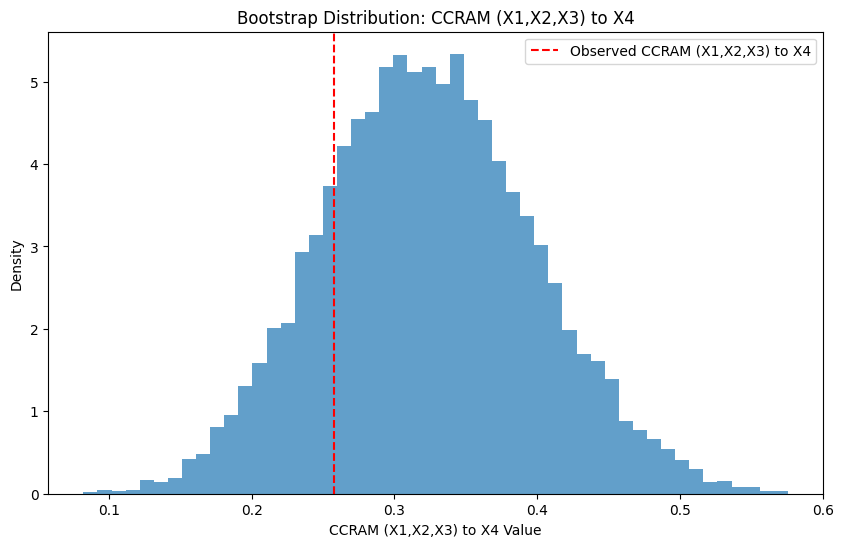

In [18]:
rda_ccram_result = bootstrap_ccram(
    rda_contingency_table,
    predictors=[1, 2, 3],
    response=4,
    confidence_level=0.95,
    method="percentile",
    n_resamples=9999
)

In [19]:
print(f"Metric Name: {rda_ccram_result.metric_name}")
print(f"Observed Value: {rda_ccram_result.observed_value:.4f}")
print(f"95% CI: ({rda_ccram_result.confidence_interval[0]:.4f}, {rda_ccram_result.confidence_interval[1]:.4f})")
print(f"Standard Error: {rda_ccram_result.standard_error:.4f}")
print(f"Bootstrap Distribution: {type(rda_ccram_result.bootstrap_distribution)}")

Metric Name: CCRAM (X1,X2,X3) to X4
Observed Value: 0.2576
95% CI: (0.1838, 0.4748)
Standard Error: 0.0744
Bootstrap Distribution: <class 'numpy.ndarray'>


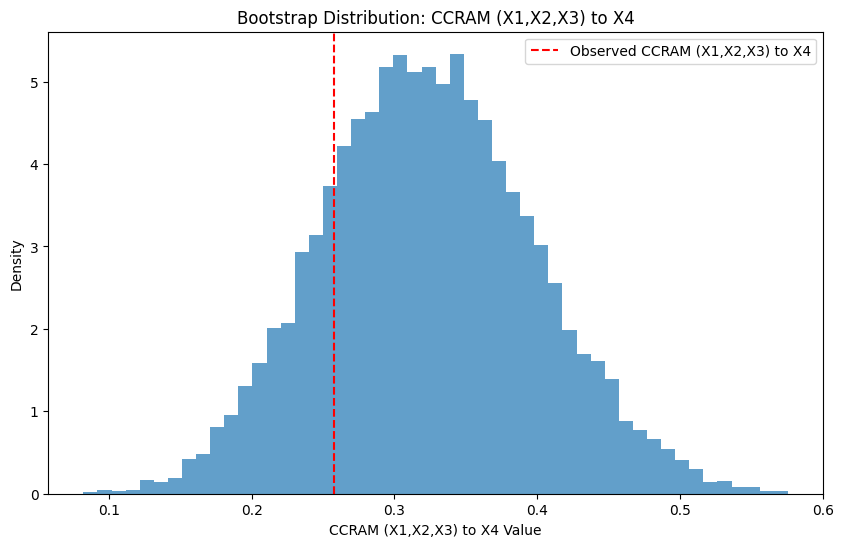

In [20]:
rda_ccram_result.histogram_fig

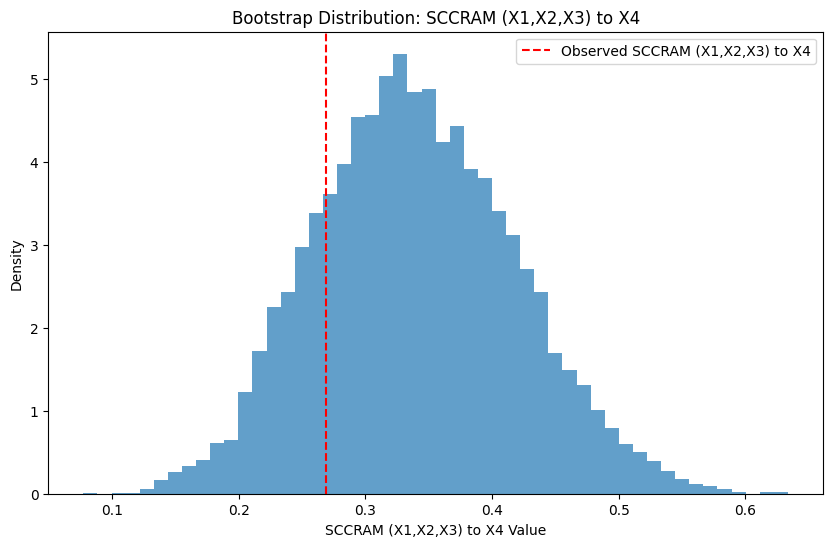

In [21]:
rda_sccram_result = bootstrap_ccram(
    rda_contingency_table,
    predictors=[1, 2, 3],
    response=4,
    confidence_level=0.95,
    scaled=True,
    method="percentile",
    n_resamples=9999
)

In [22]:
print(f"Metric Name: {rda_sccram_result.metric_name}")
print(f"Observed Value: {rda_sccram_result.observed_value:.4f}")
print(f"95% CI: ({rda_sccram_result.confidence_interval[0]:.4f}, {rda_sccram_result.confidence_interval[1]:.4f})")
print(f"Standard Error: {rda_sccram_result.standard_error:.4f}")
print(f"Bootstrap Distribution: {type(rda_sccram_result.bootstrap_distribution)}")

Metric Name: SCCRAM (X1,X2,X3) to X4
Observed Value: 0.2687
95% CI: (0.1959, 0.5007)
Standard Error: 0.0787
Bootstrap Distribution: <class 'numpy.ndarray'>


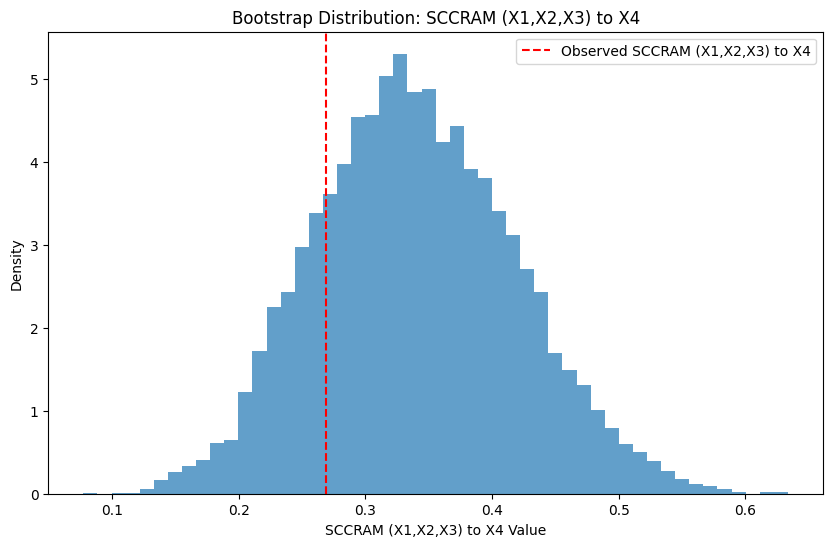

In [23]:
rda_sccram_result.histogram_fig

### Bootstrap Prediction of Categories through Checkerboard Copula Regression

In [25]:
rda_prediction_matrix = bootstrap_predict_category_summary(
    rda_contingency_table,
    predictors=[1, 2, 3],
    predictors_names=["X1", "X2", "X3"],
    response=4,
    response_name="Y = X4",
    n_resamples=9999
)
print("\nPrediction Matrix:")
rda_prediction_matrix


Prediction Summary (% of bootstrap samples)
--------------------------------------------------------------------------------
           X1=0                                      X1=1                                   
           X2=0          X2=1          X2=2          X2=0          X2=1          X2=2       
           X3=0   X3=1   X3=0   X3=1   X3=0   X3=1   X3=0   X3=1   X3=0   X3=1   X3=0   X3=1
Y = X4=0   0.1%   0.0%   1.5%   0.2%   0.0%   0.0%   1.8%   1.8%   0.5%   1.8%   0.0%   0.7%
Y = X4=1   0.1%   0.0%   0.0%   0.0%   0.0%   1.5%   0.0%   3.7%   0.0%   3.0%   4.4%  11.4%
Y = X4=2   0.6%   0.6%   0.0%   7.6%   3.0%  51.6%   0.0%  17.2%   2.5%   6.9%  76.9%  72.5%
Y = X4=3   7.1%  33.5%   0.0%  42.8%  82.1%  46.5%  11.3%  48.0%  42.8%  36.7%  18.5%  15.5%
Y = X4=4  69.9%  65.7%  65.7%  46.5%  15.0%   0.4%  86.8%  26.4%  54.1%  51.7%   0.1%   0.0%
Y = X4=5  22.3%   0.1%  32.8%   2.8%   0.0%   0.0%   0.0%   2.9%   0.0%   0.0%   0.0%   0.0%
-------------------------------------

X1=0                                                         \
               X2=0                  X2=1                  X2=2              
               X3=0       X3=1       X3=0       X3=1       X3=0       X3=1   
Y = X4=0   0.080008   0.000000   1.540154   0.190019   0.000000   0.000000   
Y = X4=1   0.120012   0.000000   0.000000   0.000000   0.000000   1.530153   
Y = X4=2   0.570057   0.630063   0.000000   7.630763   2.960296  51.615162   
Y = X4=3   7.090709  33.543354   0.000000  42.844284  82.058206  46.484648   
Y = X4=4  69.886989  65.726573  65.686569  46.514651  14.981498   0.370037   
Y = X4=5  22.252225   0.100010  32.773277   2.820282   0.000000   0.000000   

               X1=1                                                         
               X2=0                  X2=1                  X2=2             
               X3=0       X3=1       X3=0       X3=1       X3=0       X3=1  
Y = X4=0   1.820182   1.810181   0.530053   1.770177   0.000000   0.680068  
Y = X4=1   0.000000   3.650365   0.000000   3.000300   4.410441  11.361136  
Y = X4=2   0.000000  17.211721   2.510251   6.860686  76.937694  72.507251  
Y = X4=3  11.331133  48.004800  42.824282  36.653665  18.541854  15.451545  
Y = X4=4  86.848685  26.432643  54.135414  51.715172   0.110011   0.000000  
Y = X4=5   0.000000   2.890289   0.000000   0.000000   0.000000   0.000000

In [29]:
print("Basic DataFrame Info:")
print(rda_prediction_matrix.info())

print("\nDataFrame Shape:")
print(rda_prediction_matrix.shape)

Basic DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, Y = X4=0 to Y = X4=5
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (X1=0, X2=0, X3=0)  6 non-null      float64
 1   (X1=0, X2=0, X3=1)  6 non-null      float64
 2   (X1=0, X2=1, X3=0)  6 non-null      float64
 3   (X1=0, X2=1, X3=1)  6 non-null      float64
 4   (X1=0, X2=2, X3=0)  6 non-null      float64
 5   (X1=0, X2=2, X3=1)  6 non-null      float64
 6   (X1=1, X2=0, X3=0)  6 non-null      float64
 7   (X1=1, X2=0, X3=1)  6 non-null      float64
 8   (X1=1, X2=1, X3=0)  6 non-null      float64
 9   (X1=1, X2=1, X3=1)  6 non-null      float64
 10  (X1=1, X2=2, X3=0)  6 non-null      float64
 11  (X1=1, X2=2, X3=1)  6 non-null      float64
dtypes: float64(12)
memory usage: 624.0+ bytes
None

DataFrame Shape:
(6, 12)


### Permutation Testing for CCRAM & SCCRAM Metrics

/Users/dhyeymavani/.pyenv/versions/ccrvam/lib/python3.13/site-packages/scipy/stats/_resampling.py:1492: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


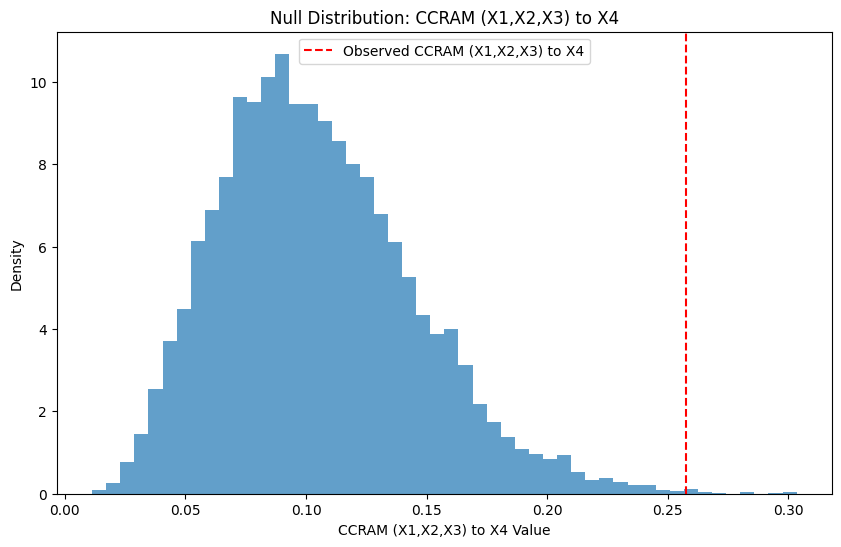

In [30]:
rda_perm_result = permutation_test_ccram(
    rda_contingency_table,
    predictors=[1, 2, 3],
    response=4,
    alternative='greater',
    n_resamples=9999
)

In [31]:
print(f"Metric Name: {rda_perm_result.metric_name}")
print(f"Observed Value: {rda_perm_result.observed_value:.4f}")
print(f"P-Value: {rda_perm_result.p_value:.4f}")
print(f"Null Distribution: {type(rda_perm_result.null_distribution)}")

Metric Name: CCRAM (X1,X2,X3) to X4
Observed Value: 0.2576
P-Value: 0.0015
Null Distribution: <class 'numpy.ndarray'>


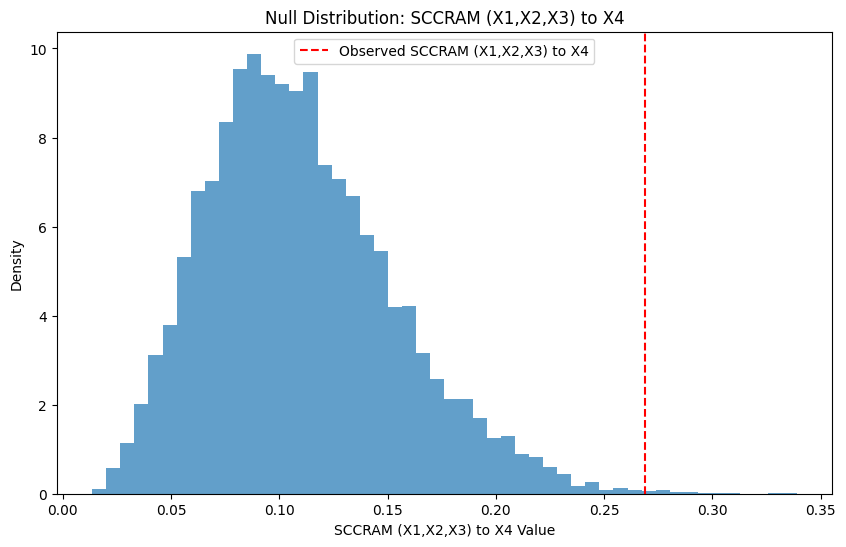

In [32]:
rda_scaled_perm_result = permutation_test_ccram(
    rda_contingency_table,
    predictors=[1, 2, 3],
    response=4,
    scaled=True,
    alternative='greater',
    n_resamples=9999
)

In [33]:
print(f"Metric Name: {rda_scaled_perm_result.metric_name}")
print(f"Observed Value: {rda_scaled_perm_result.observed_value:.4f}")
print(f"P-Value: {rda_scaled_perm_result.p_value:.4f}")
print(f"Null Distribution: {type(rda_scaled_perm_result.null_distribution)}")

Metric Name: SCCRAM (X1,X2,X3) to X4
Observed Value: 0.2687
P-Value: 0.0020
Null Distribution: <class 'numpy.ndarray'>
